# Part II: Presentation
### Inference

In [1]:
import numpy as np
import pandas as pd
import scipy as stats
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt
import os

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

#### New Citation
'Machine Learning Regression Project - Predicting Housing Sales' by Jeff Hale
* https://www.kaggle.com/discdiver/regression-project-predicting-housing-sales

Others are same as Part I

In [2]:
training_nodums = pd.read_csv('./datasets/training_cleaned_nodummies.csv', index_col=0) #includes saleprice

# merged_logged = pd.read_csv('./datasets/merged_logged_dummied.csv') #includes UNLOGGED saleprice
# training_logged = merged_logged.loc[merged_logged['is_train']==1] #includes saleprice
# lasso_coefs = pd.read_csv('./datasets/lasso_coefs.csv')

## Pre-pre-processing
The methods for initial cleaning - handling nulls, classifying features, preliminary EDA - are outlined in [Technical Report Part I](https://git.generalassemb.ly/young-helen/project_2/blob/master/p2_take_two.ipynb).  That report continues to transform data for predictive modeling.  Here I start with the mostly-clean data *before* transformations and dummification, and modify it to answer this problem statement.

In [3]:
#training_nodums.isnull().sum().sort_values(ascending=False)

In [4]:
#source Gwen
def convert_snake_case(label, capitalize_first=True, capitalize_all=False):
    if capitalize_all:
        return ' '.join([word.capitalize() for word in label.split('_')])
    elif capitalize_first:
        return ' '.join([word.capitalize() if i == 0 else word for i, word in enumerate(label.split('_'))])
    else:
        return ' '.join([word for word in label.split('_')])

There is one transformation that does need to be undone: return discrete scales to original form for interpretation.  (They are currently squared)

In [5]:
#undo past mod of ordinal scale
discretios = ['bsmt_qual','bsmt_cond', 'fireplace_qu','garage_qual', 'garage_cond',
              'kitchen_qual', 'exter_qual','exter_cond','heating_qc','garage_finish', 
              'bsmt_exposure','bsmtfin_type_1','bsmtfin_type_2', 'pool_qc', 'fence', #nans_to_zeros
              'lot_shape','utilities','land_slope', 'electrical','functional', #nans_to_median
              'overall_qual', 'overall_cond'] #additional

training_nodums[discretios] = training_nodums[discretios].apply(lambda x: x**0.5)

A second takeaway from the initial cleaning is that the target variable - saleprice - should be log transformed to better adhere to assumptions of normality:

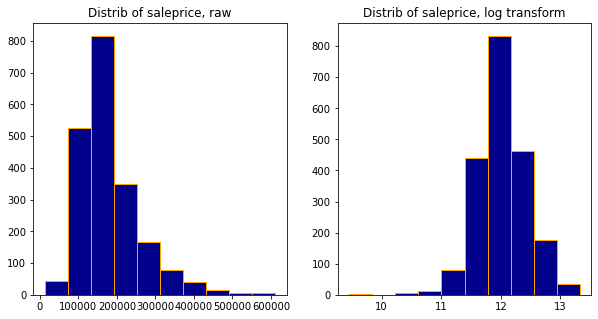

In [6]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title('Distrib of saleprice, raw')
ax1.hist(training_nodums['saleprice'], color = 'darkblue', ec='orange')

ax2 = plt.subplot(1,2,2)
ax2.set_title('Distrib of saleprice, log transform')
ax2.hist(np.log(training_nodums['saleprice']),color='darkblue', ec='orange');

In [7]:
training_nodums['saleprice'] = np.log1p(training_nodums['saleprice'])

## Problem Statement, and audience:
The goal of this presentation is to inform an audience of homeowners with remodel aspirations how to best improve the value of their property.  A complete answer to this question would be a model that takes a specific valuation goal along with details of the property, and return the home modification/s that could achieve that goal.  Alas, I am only 6kyu.

This presentation strives for the more modest deliverable of pointing renovators towards the most valuable accessories or attributes within their control.  Presumably the audience is not signing up for a complete tear down, is not capable of expanding beyond current property lines, nor capable of retroinstalling new foundation.

This problem statement requires very different treatment than the kaggle element of this project, so most of the analysis is unique.  However, at some point I utilize coefficients and relationships defined in the kaggle modeling process.  Which will be referenced and linked where appropriate.

## Step 1: Simplify
This audience is homeowners.  They own their home and are looking to remodel or add value in whatever way.  Many features, however strongly correlated with saleprice, are immutable.  These will be removed from the data so we are left with mostly features that can be the target of renovation.

Immutable features:
* Neighborhood
* Lot Configuration, Lot Area, Lot Frontage
* Alley access
* MS Zoning
* Building type
* Land Contour
* Condition 1 and 2: 'proximity to various conditions' like arterial street, railroad, etc
* ID, PID
* Year Built
* Basement Exposure
* Foundation

---
Additional features have also been removed for redundancy or vagueness:
* Basement Finish Type 2, Basement sqft 2
* Fireplaces: fireplace quality is left in place, which also serves as a Y/N indicator
* Garage cars: collinear with Garage Area
* Exterior 2
* 2nd floor sf: lots of sqft and 2nd floor metrics already
* Kitchen count: accounted for in kitchen_quality
* Overall Qual and Overall Cond: not redundant, but not helpful.
* MS Subclass: once rebinned into 1-story vs 2-story homes, it was redundant to information in 'House Style'
* Functional
* Masonry Veneer Type
* Misc Val


In [8]:
cols_to_drop = ['id','ms_subclass','overall_qual','overall_cond','neighborhood', 'pid','ms_zoning', 'lot_frontage', 'lot_area','land_slope',
              'street','alley','lot_shape','land_contour','lot_config', 'condition_1',
              'condition_2', 'bldg_type','year_built','functional','exterior_2nd','bsmt_exposure',
              'bsmtfin_type_2', 'bsmtfin_sf_2','2nd_flr_sf', 'fireplaces','garage_cars','misc_val',
              'yr_sold', 'sale_type', 'mo_sold','foundation', 'mas_vnr_type', 'kitchen_abvgr']

In [9]:
training_nodums.drop(columns=cols_to_drop, inplace=True)

In [10]:
#training_nodums.columns

## Step 2: Rescale and combine redundant features
Many of the discrete scales here can be simplified to fewer levels.  For ordinal objects, many of them have already been transformed from object classes to numeric scales via [Part I](https://git.generalassemb.ly/young-helen/project_2/blob/master/p2_take_two.ipynb).  Here I will consolidate these scales for easier interpretability.

In [11]:
#All the dictionaries
# subclass_dict = {20:'1 story', 30:'1 story', 40: '1 story',
#                 45: '2 story', 50: '2 story', 60: '2 story', 70: '2 story',
#                 75: '2 story', 80: '2 story', 85: '2 story',
#                 90: 'multifam', 190:'multifam',
#                 120: 'PUD', 150: 'PUD', 160: 'PUD', 180: 'PUD'}

house_style_dict = {'1Story':'1Story','1.5Fin':'2Story', '2Story':'2Story',
                    'SLvl':'2Story', 'SFoyer': '2Story',
                   '2.5Unf':'Unf', '1.5Unf':'Unf', '2.5Fin':'2Story'}

garage_type_dict = {'Attchd':'Attchd', 'BuiltIn':'Attchd', 'Basment':'Attchd', 
                    'CarPort':'Detchd', 'Detchd':'Detchd', 'None':'None', '2Types':'2Types'}

heat_dict = {'Floor':'Gas Central', 'GasA':'Gas Central', 'GasW':'Gas Central', 
             'Grav':'Gas Central', 'Wall':'Other', 'OthW':'Other'}

elec_dict = {5:5, 1:1, 2:1, 3:1, 4:1}

In [12]:
# training_nodums['ms_subclass']= training_nodums['ms_subclass'].map(subclass_dict)

Housing style, garag type, heating, and electrical can similarly be trimmed to fewer levels.

In [13]:
features = ['house_style', 'garage_type', 'heating', 'electrical']
dicts = [house_style_dict, garage_type_dict, heat_dict, elec_dict]
for i,j in zip(features, dicts):
    training_nodums[i] = training_nodums[i].map(j)
#there's gotta be a way to do this where default is x instead of NaN if key not in dict

And bathrooms are bathrooms, man.

In [14]:
#sum bathrooms for above-ground house
training_nodums['bath'] = training_nodums['full_bath'] + (.5*training_nodums['half_bath'])
#binary for basement bathrooms
training_nodums['bsmt_bath']= np.where(training_nodums['bsmt_half_bath']+training_nodums['bsmt_full_bath']>0, 1, 0)

In [15]:
training_nodums.drop(columns = ['bsmt_full_bath','bsmt_half_bath','full_bath','half_bath'], inplace=True)

### Basic summary stats
Glimpse of typical Ames home metrics

In [16]:
summstats = training_nodums.copy()
summstats['saleprice'] = np.expm1(summstats['saleprice'])
summstats[['saleprice','gr_liv_area','totrms_abvgrd','bath','garage_area','bsmt_qual']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
saleprice,2049.0,181479.02,79295.91,12789.0,129800.0,162500.0,214000.0,611657.0
gr_liv_area,2049.0,1495.55,485.78,334.0,1128.0,1444.0,1728.0,3820.0
totrms_abvgrd,2049.0,6.43,1.54,2.0,5.0,6.0,7.0,14.0
bath,2049.0,1.76,0.64,0.0,1.0,2.0,2.0,5.0
garage_area,2049.0,472.65,214.70,0.0,319.0,480.0,576.0,1356.0
bsmt_qual,2049.0,3.49,0.90,0.0,3.0,4.0,4.0,5.0


## Step 3: Dummify categories

In [17]:
training_dums = pd.get_dummies(training_nodums, drop_first=False)

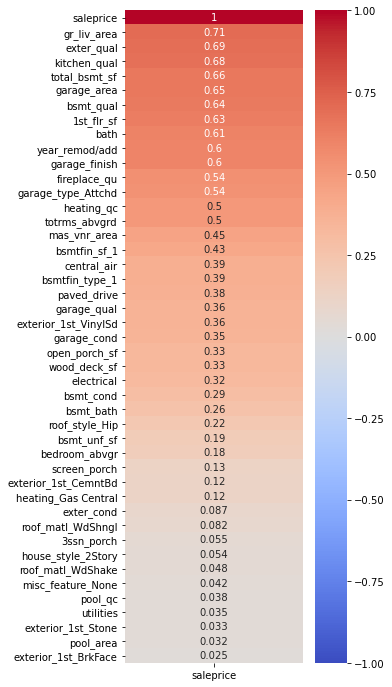

In [18]:
plt.figure(figsize=(4,12))
sp_corr= training_dums.corr()[['saleprice']].sort_values('saleprice', ascending=False).head(45)
sns.heatmap(sp_corr, cmap = 'coolwarm', annot=True, vmin=-1, vmax=1);

## Step 4: Bin to renovation categories

In [19]:
def bin(keyword):
    bin=['saleprice']
    for col in training_dums.columns:
        if keyword in col:
            bin.append(col)
    return bin
    
basement = bin('bsmt')
garage = bin('garage')
exterior = bin('exterior')
exterior.extend(['mas_vnr_area','paved_drive'])
roof = bin('roof')
porch = bin('porch')
porch.extend(['wood_deck_sf'])
utilities = bin('heat')
utilities.extend(['utilities', 'central_air','electrical'])
misc = bin('misc')
misc.extend(['pool_area','pool_qc', 'kitchen_qual','fence', 'fireplace_qu'])
struc = bin('house')


## Step 5: correlation
Look at the correlation for each of these 'renovation category' bins.  Which elements are most tied to home value?  The idea here was that if a homeowner wants to focus on a certain realm (ie garage), they could view that particular heatmap and see where their energy is best spent.  Ultimately, it was not used as such in presentation, but that is the motive for 100 heatmaps.  I will revisit to organize them into a subplot if time, but I still don't see it being a particularly informative visual.


* Misc Add-ons: kitchen upgrades, fireplace upgrade?
    * No pay back for fence, shed, second garage
* Garage: finish! simple dry-wall layer is akin to increasing square footage
    * according to realtor metrics, as long as there's a bare minimum dry-wall coverage everywhere, it's "finished".  No insulation or materials requirements.


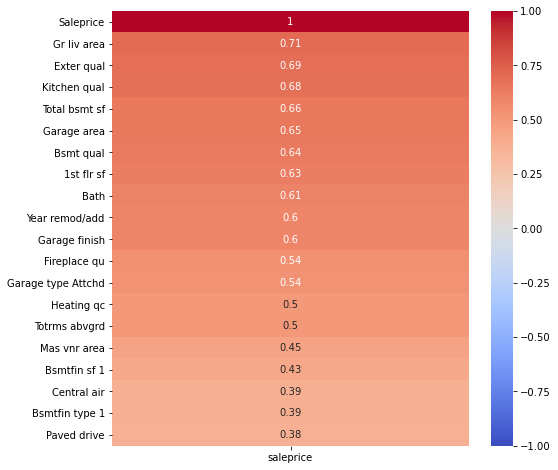

In [20]:
plt.figure(figsize=(8,8))
sp_corr= training_dums.corr()[['saleprice']].sort_values('saleprice', ascending=False).head(20)
sns.heatmap(sp_corr, cmap = 'coolwarm', annot=True, vmin=-1, vmax=1, 
            yticklabels=[convert_snake_case(i) for i in sp_corr.index]);

In [21]:
def heatfeat(features, target, color):
    plt.figure(figsize=(4,6))
    corr = training_dums[features].corr()[[target]].sort_values(target, ascending=False)
    sns.heatmap(corr, cmap=color, annot=True, vmin=-1, vmax=1, 
               yticklabels=[convert_snake_case(i) for i in corr.index])

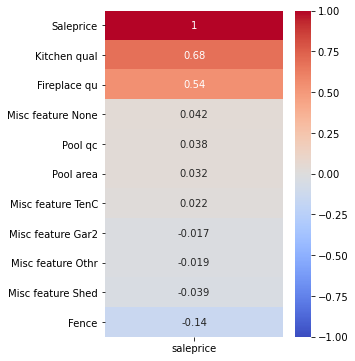

In [22]:
heatfeat(misc, 'saleprice', 'coolwarm')

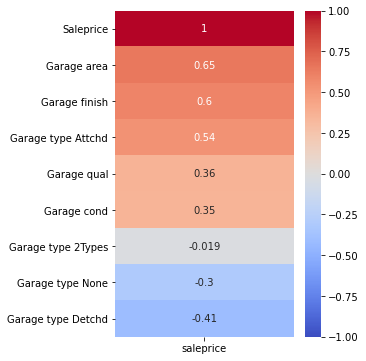

In [23]:
heatfeat(garage, 'saleprice', 'coolwarm')

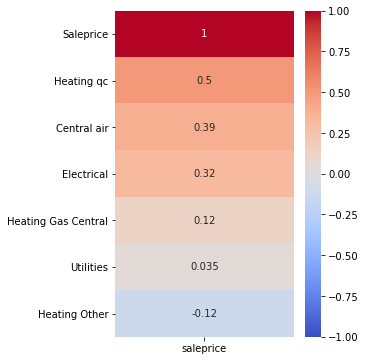

In [24]:
heatfeat(utilities, 'saleprice', 'coolwarm')

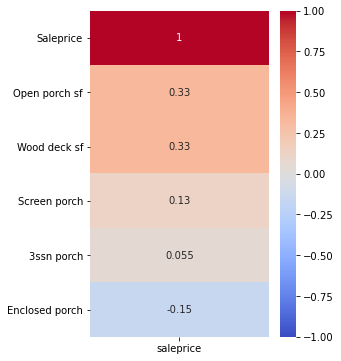

In [25]:
heatfeat(porch, 'saleprice', 'coolwarm') 
#open_porch_sf of interest bc per unit change could be big gains for big porch

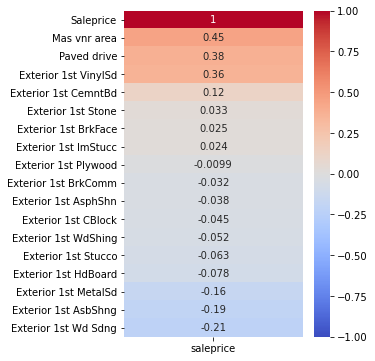

In [26]:
heatfeat(exterior, 'saleprice', 'coolwarm')
#not wood

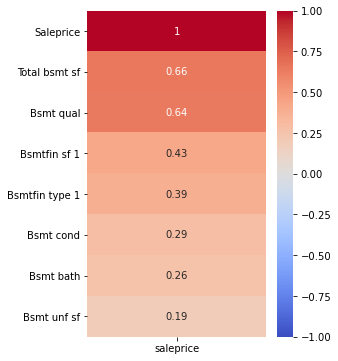

In [27]:
heatfeat(basement, 'saleprice', 'coolwarm')

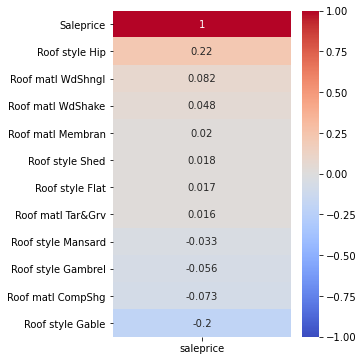

In [28]:
heatfeat(roof, 'saleprice', 'coolwarm')

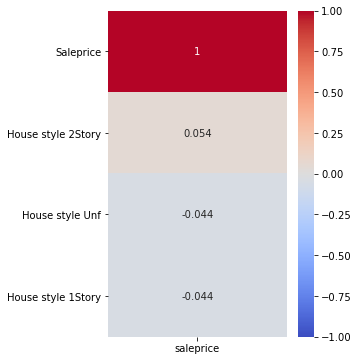

In [29]:
heatfeat(struc, 'saleprice', 'coolwarm')

Now we'll look at the distributions of the continuous variables.

Do not yet transform other variables for interpretability.

In [30]:
continuous_vars = bin('sf')
continuous_vars.extend(bin('area'))
continuous_vars = list(dict.fromkeys(continuous_vars)) #remove dupes since you ran function twice

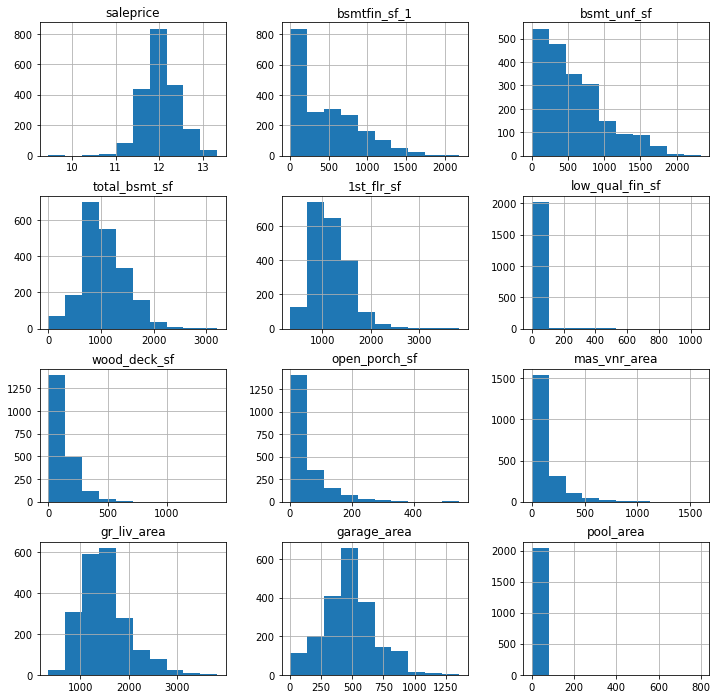

In [31]:
training_dums[continuous_vars].hist(figsize=(12,12));

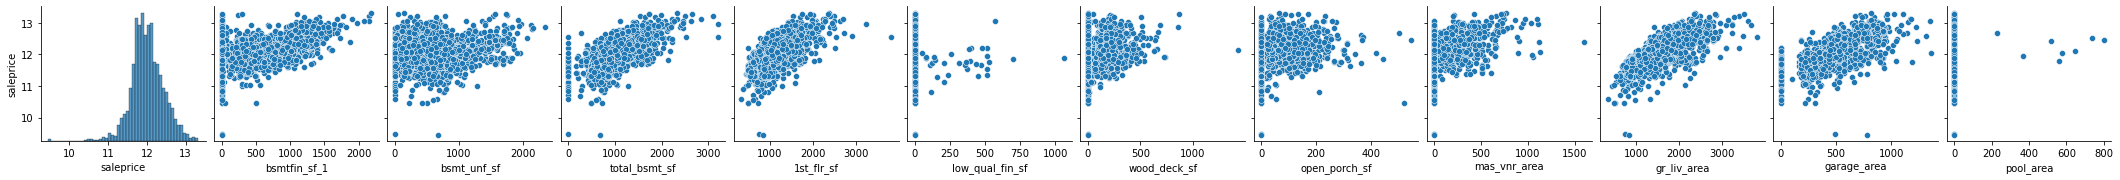

In [32]:
sns.pairplot(training_dums, x_vars=continuous_vars, y_vars=['saleprice']);

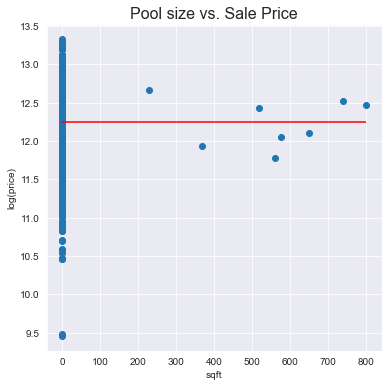

In [33]:
sns.set_style('darkgrid')
plt.figure(figsize=(6,6))
plt.scatter(x='pool_area', y='saleprice', data=training_dums)
plt.xlabel('sqft')
plt.ylabel('log(price)')
plt.hlines(y=12.25,color = 'red', xmin=0, xmax=800)
plt.title('Pool size vs. Sale Price', size=16);

## Step 6: Linear Regression
So we know what features have the strongest correlation, but what is the magnitude of that relationship?  Get interpretable coefficients via linear regression.  From the pairplot array above, we suspect definite linear relationship with most features regarding area (sqft): basement sqft, 1st floor sqft, garage area, masonry veneer area.

In [34]:
#all feature.
X = training_dums[training_dums.drop(columns='saleprice').columns]
y = training_dums['saleprice']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [36]:
lr = LinearRegression()

In [37]:
cross_val_score(lr, X_train, y_train, cv=3).mean()

0.8681958274596496

In [38]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8911365811387417, 0.8493715120507898)

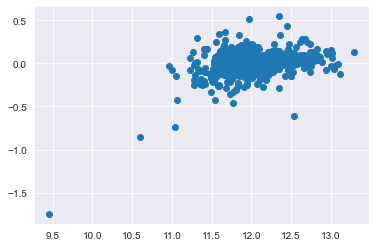

In [39]:
y_pred = lr.predict(X_test)
resids = y_test - y_pred
plt.scatter(y_test,resids);

### Coefficients: all features

In [40]:
coefs = pd.Series(lr.coef_, index=X_train.columns)
#coefs = coefs.map(lambda x: (np.exp(x)-1)*100)  #inverse transform.  But class lecture just used np.exp(coef).
coefs = pd.DataFrame(coefs.sort_values(ascending=False).round(4))

In [41]:
# coef*100 here for interpretability.
# expm1 inverse log transforms and subtracts 1.  By multiplying by 100 coef is now a percent:
# 1 unit change in feature = coef% change in target
coefs = pd.DataFrame(list(zip(X.columns, lr.coef_*100)),columns = ['Features','Coef'])
coefs.sort_values('Coef', ascending=False).round(2).head()
#doesn't add up: negative coef for bedrooms, attached garage, No Garage ranked #2...

,Features,Coef
47,roof_matl_Membran,19.73
71,garage_type_None,19.08
50,roof_matl_WdShngl,16.29
54,exterior_1st_BrkFace,12.06
25,paved_drive,11.13


## Limited features to highly correlated variables that homeowner can renovate
The above model including all features yields results that don't line up with sensibility: ie a 20% increase in price for having No garage, while an attached garage has a negative coefficient.  This is the point where I thought I was messing things up with exp() vs expm1() exponentiation, but now that I have standardized my usage throughout, the problem remains.  To address, I drop features down to the most pertinent to the research questions: those that are renovatable, economically feasible, and don't require lot expansion.

Well outperforms baseline by MSE and R2

In [42]:
X = training_dums[['kitchen_qual','bath','paved_drive','central_air','garage_finish',
                                'heating_qc','bsmtfin_type_1','mas_vnr_area']]
y=training_dums['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Dummy model:

In [43]:
#exponentiate within MSE call to undo log transform of y
def model_rmse(model, X_train, X_test, y_train, y_test):
    train_rmse = mean_squared_error(np.expm1(y_train), np.expm1(model.predict(X_train)), squared=False).round(2)
    test_rmse = mean_squared_error(np.expm1(y_test), np.expm1(model.predict(X_test)), squared=False).round(2)
    print(f'train RMSE = {train_rmse}')
    print(f'test RMSE = {test_rmse}')

In [44]:
def resids_hist(resids, title, x_label, y_label='Frequency', size_var = 18):
    plt.figure(figsize=(6,10));
    sns.displot(x = resids);
    plt.title(title, fontsize = size_var, pad = size_var / 2);
    plt.xlabel(x_label, fontsize = size_var, labelpad = size_var/2)
    plt.xticks(fontsize=size_var/2, rotation=45)
    plt.ylabel(y_label, fontsize = size_var, labelpad = size_var/2)
    plt.yticks(fontsize=size_var/2, rotation=90);

In [45]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

DummyRegressor()

In [46]:
#train, test r2
print(r2_score(np.expm1(y_train),np.expm1(dummy_model.predict(y_train))))
print(r2_score(np.expm1(y_test),np.expm1(dummy_model.predict(y_test))))

-0.03447812748665302
-0.03407311406546443


In [47]:
mean_squared_error(np.expm1(y_train), np.expm1(dummy_model.predict(y_train)),squared=False), mean_squared_error(np.expm1(y_test), np.expm1(dummy_model.predict(y_test)), squared=False)

(80551.59010103827, 80854.98557526672)

<Figure size 432x720 with 0 Axes>

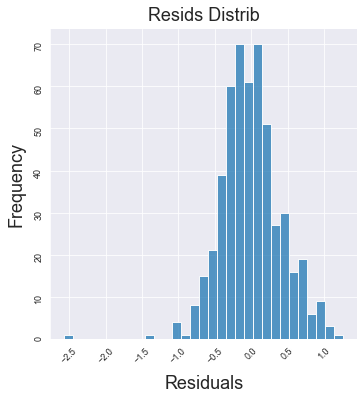

In [48]:
resids = y_test - dummy_model.predict(X_test)
resids_hist(resids, title='Resids Distrib', x_label='Residuals', y_label='Frequency', size_var=18);

In [49]:
lr=LinearRegression()

In [50]:
cross_val_score(lr, X_train, y_train, cv=3)

array([0.69414333, 0.72061575, 0.72664919])

In [51]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.7190602805479962, 0.7258783540602294)

In [52]:
model_rmse(lr, X_train, X_test, y_train, y_test)

train RMSE = 42802.16
test RMSE = 40596.75


In [53]:
y_pred = lr.predict(X_test)
resids = y_test - y_pred

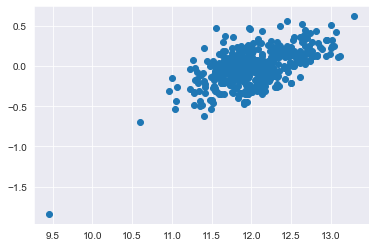

In [54]:
plt.scatter(y_test, resids)

<Figure size 432x720 with 0 Axes>

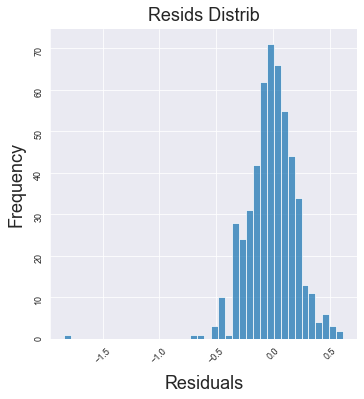

In [55]:
resids_hist(resids, title='Resids Distrib', x_label='Residuals', y_label='Frequency', size_var=18);

In [56]:
coefs = pd.DataFrame(list(zip(X.columns, (np.expm1(lr.coef_)*100))),columns = ['Features','Coef'])
coefs = coefs.sort_values('Coef', ascending=False).round(2)

In [57]:
coefs['Features']=coefs['Features'].map(lambda x: convert_snake_case(x))
coefs.to_csv('./datasets/presentation_coefs_lr.csv', index=False)
coefs # % change in y

,Features,Coef
0,Kitchen qual,21.74
1,Bath,20.89
2,Paved drive,18.42
3,Central air,16.95
4,Garage finish,7.47
5,Heating qc,3.08
6,Bsmtfin type 1,2.60
7,Mas vnr area,0.03


# Conclusions
The linear model with the hand-selected features at least has interpretability that aligns with reality - no spike in saleprice for having No garage.  Kitchen quality is vague, but there are several online projections for the average cost of kitchen remodels, so it is still quantifiable.  Bathrooms, paved driveways, and central air are more discrete units that can impart significant gains to the aspiring remodeler.

A garage or basement is 'finished' - [according to realtor speak](https://www.homelight.com/blog/does-a-finished-garage-add-value/#:~:text=First%2C%20let's%20define%20what%20the,sold%20properties%20with%20finished%20garages.) - as long as there is drywall covering beams and paint on the walls.  If that is the requirement to tick the box of 'finished' garage in the housing data collection, this is a quick and easy way to add value.  If it must be livable - insulation, crossfit gym, fooseball table - then this investment would not pay for itself.

The coefficient outputs here are the most interpretable results from this project analysis, part I and part II.  The models for prediction were VERY different than those presented above, but I also could not interpret them to homeowners in any meaningful way.  The Lasso coefficients from part I at least delineate the weight of a feature in how it affects the target.  However, most of these were related to sqare feet, and with an audience that  is working with a finite lot size, these were not very helpful.

The linear regression coefficients here can be used by stakeholders to estimate the impact a reno will have on their home value, all else held equal.  Since they are given as percents, this valuation is dependent on the starting condition of the property: there is no hard dollar amount associated with each feature in a vacuum.

Future refining would involve better binning the ordinal features to hopefully yield more instructive, interpretable coefficients.